<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
<center>Author: [Mariya Mansurova](https://www.linkedin.com/in/mariya-mansurova-04070982/), analyst & developer in Yandex.Metrics team. <br>Translated by [Ivan Zakharov](https://www.linkedin.com/in/ivan-zakharov/), ML enthusiast.
<br>All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #9 (demo)
## <center> Time series analysis

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [26]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd
from tqdm import tqdm_notebook

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

3.4.1


## Data preparation

In [74]:
df = pd.read_csv('../input/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [5]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [77]:
df.date = pd.to_datetime(df.date)

In [78]:
plotly_df(df.set_index('date')[['count']])

In [79]:
from fbprophet import Prophet

In [80]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- 3426 (yes)
- 5229
- 2744

In [10]:
df_train = df[:-predictions].copy()
pr = Prophet()
pr.fit(df_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future = pr.make_future_dataframe(periods=predictions)
forecast = pr.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2979.319903,1700.462314,2534.713007,2959.461430,2998.562903,-861.693311,-861.693311,-861.693311,-861.693311,-861.693311,-861.693311,0.0,0.0,0.0,2117.626592
379,2016-01-17,2984.727592,1857.052440,2677.172599,2963.977794,3005.292672,-720.705354,-720.705354,-720.705354,-720.705354,-720.705354,-720.705354,0.0,0.0,0.0,2264.022238
380,2016-01-18,2990.135281,2858.924649,3698.797142,2968.370519,3012.292562,281.357669,281.357669,281.357669,281.357669,281.357669,281.357669,0.0,0.0,0.0,3271.492950
381,2016-01-19,2995.542971,3121.692591,3919.056483,2972.499563,3019.429012,541.423837,541.423837,541.423837,541.423837,541.423837,541.423837,0.0,0.0,0.0,3536.966808
382,2016-01-20,3000.950660,3006.582090,3835.680662,2976.824035,3027.156845,425.547911,425.547911,425.547911,425.547911,425.547911,425.547911,0.0,0.0,0.0,3426.498570


Estimate the quality of the prediction with the last 30 points.

In [12]:
cmp_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']

predicted_part = cmp_df[-predictions:]

error_mean = np.mean(np.abs(predicted_part['e']))
error_mean_percent = np.mean(np.abs(predicted_part['p']))

print('MAPE: ', error_mean_percent)
print('MAE: ', error_mean)

MAPE:  34.502925740494526
MAE:  599.8383194732162


**<font color='red'>Question 2:</font> What is MAPE equal to?**

- 34.5 (yes)
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- 600 (yes)
- 903

## Predicting with ARIMA

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- Series is not stationary, p_value = 0.107 (yes)
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

Dickey-Fuller test: p=0.107392


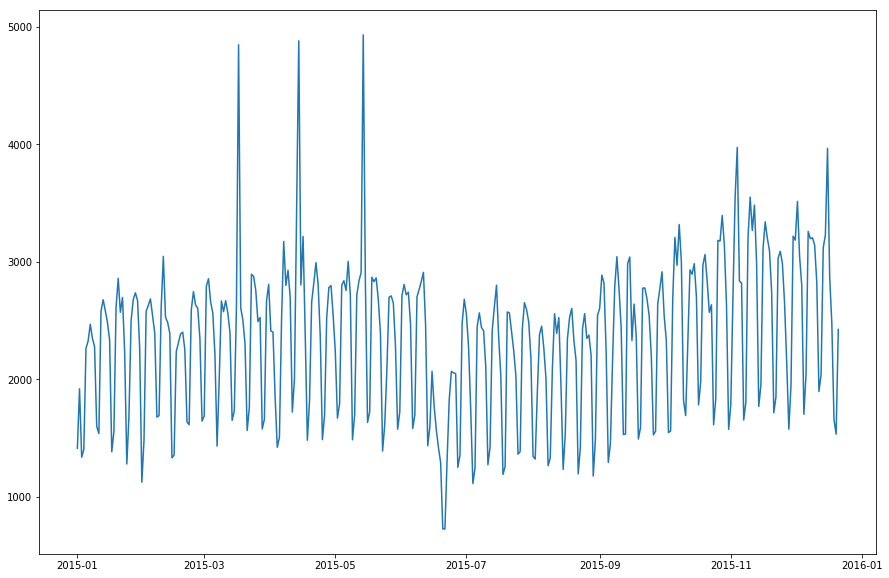

In [14]:
plt.plot(df_train['ds'].values, df_train['y'].values);
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['y'])[1])

**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1 (yes)
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

Let's try to get rid of non-stationarity by seasonality removal

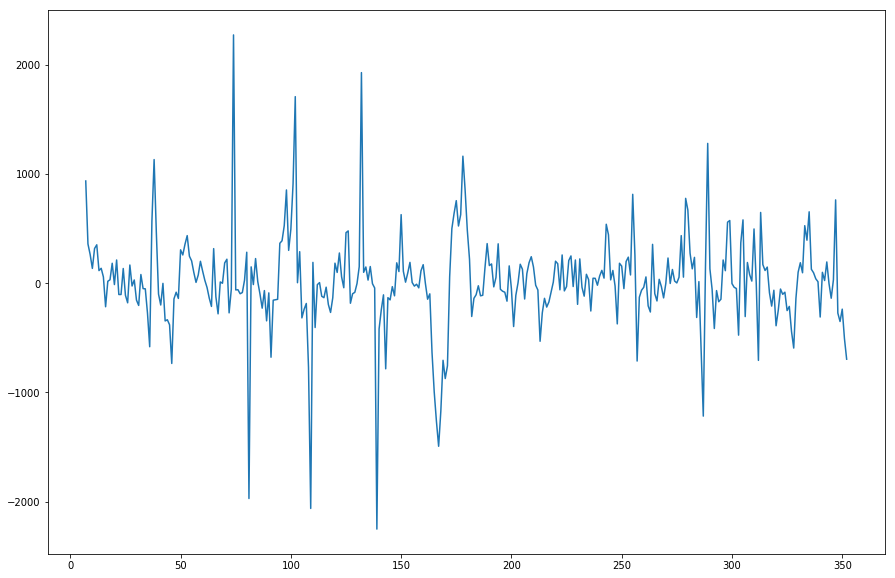

In [20]:
y_diff = df_train.y - df_train.y.shift(7)
plt.plot(y_diff.values);

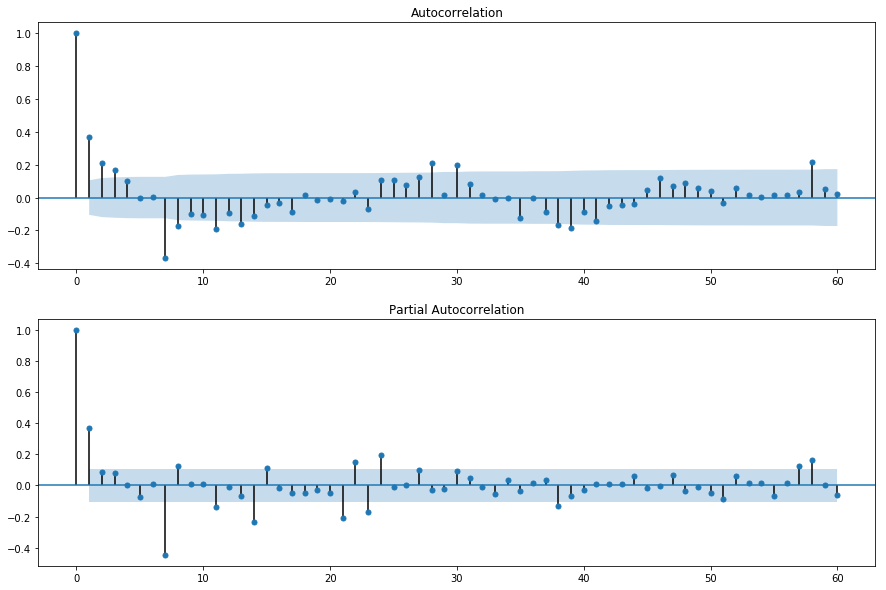

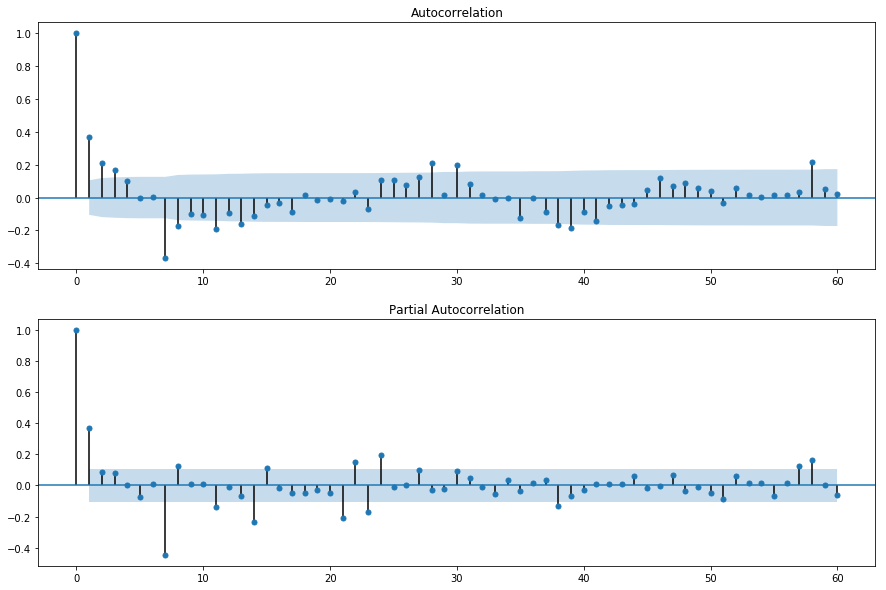

In [21]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y_diff[7:].values, lags=60, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y_diff[7:].values, lags=60, ax=ax)

Initial parameters <br>
p = 1 (from PACF) <br>
d = 1 (we had first differences) <br>
q = 1 (from ACF) <br>
P = 2 (values 1 and 7 from PACF) <br>
D = 1 (we performed seasonal differentiation) <br>
Q = 2 (values 1 and 7 from ACF)

In [23]:
from itertools import product

# setting initial values and some bounds for them
ps = range(0, 2)
d=1 
qs = range(0, 2)
Ps = range(0, 4)
D=1 
Qs = range(0, 4)
s = 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [40]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_train['y'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            print('aaa')
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [41]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [42]:
result_table.head()

,parameters,aic
0,"(1, 1, 3, 1)",5017.560474
1,"(1, 1, 3, 0)",5017.954169
2,"(1, 1, 3, 2)",5019.556181
3,"(1, 1, 3, 3)",5020.979109
4,"(1, 1, 0, 1)",5028.150318


In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [108]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [104]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df['y'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

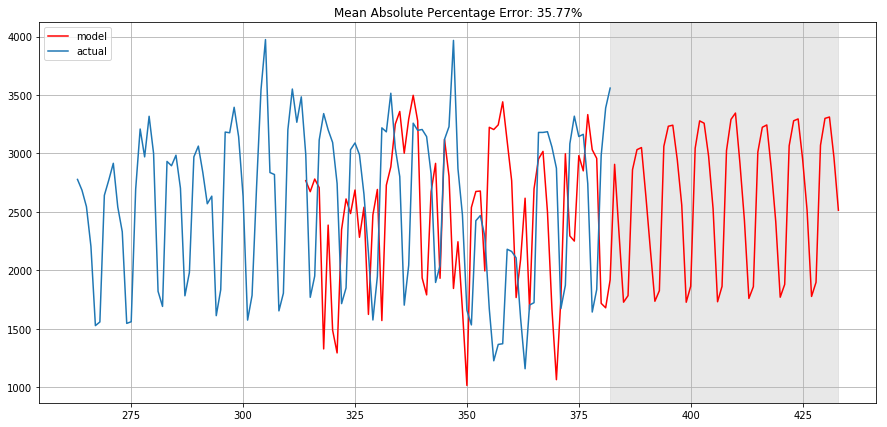

In [109]:
plotSARIMA(pd.DataFrame(df.y.values), best_model, 50)